[2017-09-20 15:11:31,520] Making new env: FrozenLake-v3



SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
episode: 0, Epsilon: 0.4995, Evaluation Average Reward: 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
episode: 100, Epsilon: 0.45194367748329795, Evaluation Average Reward: 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
episode: 200, Epsilon: 0.4089150903245787, Evaluation Average Reward: 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
Done!, 1000, 0.0
episode: 300, Epsilon: 0.3699831625619

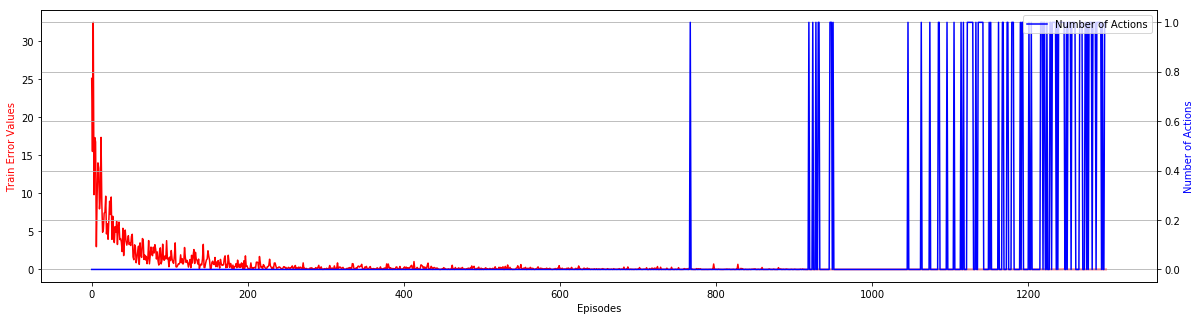

Press Enter to close the trained error figure...
Press Enter to make the trained bot play...

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
F

In [1]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from gym.envs.registration import register

register(
    id = 'FrozenLake-v3',
    entry_point = 'gym.envs.toy_text:FrozenLakeEnv',
    kwargs={
        'map_name': '8x8',
        'is_slippery': False # <-- Updated for ver.3
    }
)

# 리플레이를 저장할 리스트
REPLAY_MEMORY = deque()

# 하이퍼파라미터
INITIAL_EPSILON = 0.5
learning_rate = 0.0001
max_episodes = 10000
discount_factor = 0.9
episode_list = []
train_error_list = []
actions_list = []

# 테스트 에피소드 주기
TEST_PERIOD = 100

# src model에서 target model로 trainable variable copy 주기
COPY_PERIOD = 10

# 네트워크 클래스 구성
class DQN:
    def __init__(self, session, input_size, output_size, name="main"):
        # 네트워크 정보 입력
        self.session = session
        self.input_size = input_size
        self.output_size = output_size
        self.net_name = name
        self.hidden_size = 32
        # 네트워크 생성
        self.build_network()

    def build_network(self):
        with tf.variable_scope(self.net_name):
            # Vanilla Neural Network (Just one hidden layer)
            self.X = tf.placeholder(shape=[None, self.input_size], dtype=tf.float32)
            self.Y = tf.placeholder(shape=[None], dtype=tf.float32)

            self.W1 = tf.Variable(tf.truncated_normal(shape=[self.input_size, self.hidden_size], mean=0.0, stddev=1.0))
            self.B1 = tf.Variable(tf.zeros(shape=[self.hidden_size]))
            self.W2 = tf.Variable(tf.truncated_normal(shape=[self.hidden_size, self.output_size], mean=0.0, stddev=1.0))
            self.B2 = tf.Variable(tf.zeros(shape=[self.output_size]))

            self.L1 = tf.nn.relu(tf.matmul(self.X, self.W1) + self.B1)

            self.Qpred = tf.matmul(self.L1, self.W2) + self.B2

        # 손실 함수 및 최적화 함수
        self.action = tf.placeholder(shape=[None, self.output_size], dtype=tf.float32)
        Q_action = tf.reduce_sum(tf.multiply(self.Qpred, self.action), reduction_indices=1)
        self.loss = tf.reduce_mean(tf.square(self.Y - Q_action))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)

    # 예측한 Q값 구하기
    def predict(self, state):
        x = np.reshape(state, newshape=[1, self.input_size])
        return self.session.run(self.Qpred, feed_dict={self.X: x})

    # e-greedy 를 사용하여 action값 구함
    def egreedy_action(self, epsilon, env, state):
        if np.random.rand(1) < epsilon:
            action = env.action_space.sample()
            #print("Episode: {0}, Action: {1}".format(episode, action))
        else:
            Q_h = self.predict(state)
            action = np.argmax(Q_h)
            #print("Episode: {0}, State: {1}, Q_h: {2}, Action: {3}".format(episode, state, Q_h, action))
        return action

def update_from_memory(mainDQN, targetDQN, batch_size):
    state_batch = np.ndarray(shape=[batch_size, mainDQN.input_size])
    action_batch = np.ndarray(shape=[batch_size, mainDQN.output_size])

    minibatch = random.sample(REPLAY_MEMORY, batch_size)
    i = 0
    y_batch = []
    for sample in minibatch:
        state, action, reward, new_state, done = sample         # unpacking

        if done:
            y_batch.append(reward)
        else:
            y_batch.append(reward + discount_factor * np.max(targetDQN.predict(onehot(targetDQN.input_size, new_state))))

        one_hot_action = np.zeros(mainDQN.output_size) # [0.0, 0.0]
        one_hot_action[action] = 1

        state_batch[i] = state
        action_batch[i] = one_hot_action
        i += 1

    # DQN 알고리즘으로 학습
    loss_value, _ = mainDQN.session.run([mainDQN.loss, mainDQN.optimizer],
                                        feed_dict={mainDQN.X: state_batch, mainDQN.Y: y_batch, mainDQN.action: action_batch})
    return loss_value

def bot_play(DQN, env, isLast):
    """
    See our trained network in action
    """
    state = env.reset()
    reward_sum = 0
    done = False
    num_action = 0
    while not done and num_action < 1000:
        if isLast: env.render()
        action = np.argmax(DQN.predict(onehot(env.observation_space.n, state)))
        new_state, reward, done, info = env.step(action)
        reward_sum += reward
        state = new_state
        num_action += 1
        if done or num_action >= 1000:
            print("Done!, {0}, {1}".format(num_action, reward_sum))

    return reward_sum

def draw_error_values():
    fig = plt.figure(figsize=(20, 5))
    plt.ion()
    ax1 = plt.subplot(111)
    ax2 = ax1.twinx()
    ax1.plot(episode_list[0:], train_error_list[0:], 'r', label='Train Error Values')
    ax2.plot(episode_list[0:], actions_list[0:], 'b', label='Number of Actions')
    ax1.set_ylabel('Train Error Values', color='r')
    ax2.set_ylabel('Number of Actions', color='b')
    ax1.set_xlabel('Episodes')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()
    input("Press Enter to close the trained error figure...")
    plt.close(fig)


def get_copy_var_ops(src_scope_name='main', target_scope_name='target'):
    op_holder = []

    src_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=src_scope_name)
    target_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=target_scope_name)

    for src_var, target_var in zip(src_vars, target_vars):
        op_holder.append(target_var.assign(src_var.value()))

    return op_holder

def saveModel(session, src_scope_name='main', path='./cartpole.ckpt'):
    src_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=src_scope_name)
    tf.train.Saver(src_vars).save(session, path)
    print("Model saved successfully!")

def onehot(input_size, state):
    return np.eye(input_size)[state]

if __name__ == "__main__":
    env = gym.make("FrozenLake-v3")
    input_size = env.observation_space.n     # 4  action (키보드)
    output_size = env.action_space.n         # 2

    # 미니배치 - 꺼내서 사용할 리플레이 갯수
    BATCH_SIZE = 32

    with tf.Session() as sess:
        # DQN 클래스의 mainDQN 인스턴스 생성
        mainDQN = DQN(sess, input_size, output_size, name='main')
        targetDQN = DQN(sess, input_size, output_size, name='target')

        # 변수 초기화
        init = tf.global_variables_initializer()
        sess.run(init)
        epsilon = INITIAL_EPSILON

        copy_ops = get_copy_var_ops(src_scope_name='main', target_scope_name='target')
        sess.run(copy_ops)

        state = env.reset()
        env.render()
        for episode in range(max_episodes):
            state = env.reset()
            rAll = 0
            done = False
            epsilon *= 0.999

            while not done:
                #env.render()
                # action을 수행함 --> Get new state and reward from environment
                action = mainDQN.egreedy_action(epsilon, env, onehot(input_size, state))
                new_state, reward, done, _ = env.step(action)

                # state, action, reward, next_state, done 을 메모리에 저장
                REPLAY_MEMORY.append((onehot(input_size, state), action, reward, new_state, done))

                # 메모리에 10000개 이상의 값이 들어가면 가장 먼저 들어간 것부터 삭제
                if len(REPLAY_MEMORY) > 10000:
                    REPLAY_MEMORY.popleft()

                # REPLAY_MEMORY 크기가 BATCH_SIZE 보다 크면 학습
                if len(REPLAY_MEMORY) > BATCH_SIZE:
                    mean_loss_value = update_from_memory(mainDQN, targetDQN, BATCH_SIZE)

                rAll += reward
                state = new_state

            if len(REPLAY_MEMORY) > BATCH_SIZE:
                episode_list.append(episode)
                train_error_list.append(mean_loss_value)
                actions_list.append(rAll)

            if episode != 0 and episode % COPY_PERIOD == 0:
                a = sess.run(copy_ops)

            if episode % TEST_PERIOD == 0:
                total_reward = 0
                for i in range(10):
                    total_reward += bot_play(mainDQN, env, False)

                ave_reward = total_reward / 10
                print("episode: {0}, Epsilon: {1}, Evaluation Average Reward: {2}".format(episode,epsilon, ave_reward))
                if ave_reward >= 1.0:
                    break

        saveModel(sess, src_scope_name='main', path='./cartpole.ckpt')

        env.reset()
        env.close()
        draw_error_values()

        input("Press Enter to make the trained bot play...")
        bot_play(mainDQN, env, True)

